In [1]:
# Imports
from torch.nn.functional import binary_cross_entropy
from torch.utils.data import DataLoader
import esm
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# Accessing GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data = pd.read_csv('ARSS-90-seq+stru.csv', header=None, names=['sequence', 'label', 'structure'])

In [4]:
# Removing unknown amino acids
unknown_aa = ['O', 'U', 'X']

# Create a mask to identify sequences containing any of the unknown amino acids
mask = data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))

# Filter the DataFrame to keep only the rows where the sequence does not contain any unknown amino acids
data = data[mask == False] 

In [5]:
# Splitting into train, val, and test sets
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
from ESM2Dataset import ESM2Dataset
from preprocessing import collate_fn

# Load ESM alphabet
esm_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

sequence = train_df['sequence'].iloc[0]

# Process sequence through batch converter
tokens = batch_converter([(None, sequence)])

_, _, encoded_sequence = tokens
# print("Encoded sequence:", encoded_sequence)

In [7]:
# Create dataset
train_dataset = ESM2Dataset(train_df, batch_converter)
val_dataset = ESM2Dataset(val_df, batch_converter)
test_dataset = ESM2Dataset(test_df, batch_converter)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [8]:
def train_model(model, train_loader, val_loader, epochs, device):
    """
    Trains the model with the given train and validation dataloaders.
    Implements early stopping to avoid overfitting.
    """
    
    # Move model to device
    model.to(device)

    # Define the criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # 0.00005

    # Early stopping configuration
    patience = 3 # Number of epochs without val loss improvement to stop
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for sequences, attention_masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            # Send data to device
            sequences = sequences.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device).float()
            labels = labels.unsqueeze(1)  # Shape: [batch_size, 1]
            
            # Forward pass
            optimizer.zero_grad()
            # Only taking outputs and not attention maps
            outputs = model(sequences, attention_mask=attention_masks)

            # Compute the loss
            loss = criterion(outputs, labels)
            loss.backward()

            # Optimizer step
            optimizer.step()

            # Accumulate the training loss
            train_loss += loss.item()

        # Average the training loss across all batches
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for sequences, attention_masks, labels in tqdm(val_loader, desc="Validating"):
                # Send validation data to the device
                sequences = sequences.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device).float()
                labels = labels.unsqueeze(1)  # Shape: [batch_size, 1]

                # Forward pass
                outputs = model(sequences, attention_mask=attention_masks)

                # Compute the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Average validation loss
        avg_val_loss = val_loss / len(val_loader)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Print metrics for the epoch
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

        # Check for early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
            break

In [9]:
from ESM2Classifier import ESM2Classifier
model = ESM2Classifier(esm_model = esm_model, num_heads=8, num_layers=3)
train_model(model, train_loader, val_loader, epochs=30, device=device)

/home/jmontour15/dl_final/ESM2Dataset.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, dtype=torch.long).squeeze(0)
/home/jmontour15/dl_final/preprocessing.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_tensors = [torch.tensor(tokens, dtype=torch.long) for tokens in tokens_list]


alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.71it/s]

Epoch 1 | Train Loss: 0.3821 | Validation Loss: 0.2968




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.67it/s]

Epoch 2 | Train Loss: 0.3106 | Validation Loss: 0.2838




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:11<00:00, 19.53it/s]

Epoch 3 | Train Loss: 0.2828 | Validation Loss: 0.2946




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.65it/s]

Epoch 4 | Train Loss: 0.2673 | Validation Loss: 0.2463




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.58it/s]

Epoch 5 | Train Loss: 0.2476 | Validation Loss: 0.2252




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.64it/s]

Epoch 6 | Train Loss: 0.2168 | Validation Loss: 0.2793




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.65it/s]

Epoch 7 | Train Loss: 0.2078 | Validation Loss: 0.2083




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.64it/s]

Epoch 8 | Train Loss: 0.1839 | Validation Loss: 0.2145




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:11<00:00, 19.41it/s]

Epoch 9 | Train Loss: 0.1679 | Validation Loss: 0.2038




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.56it/s]

Epoch 10 | Train Loss: 0.1588 | Validation Loss: 0.2009




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:11<00:00, 19.54it/s]

Epoch 11 | Train Loss: 0.1512 | Validation Loss: 0.2136




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.56it/s]

Epoch 12 | Train Loss: 0.1339 | Validation Loss: 0.1990




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.57it/s]

Epoch 13 | Train Loss: 0.1213 | Validation Loss: 0.2406




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 19.61it/s]

Epoch 14 | Train Loss: 0.1137 | Validation Loss: 0.2026



Validating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:11<00:00, 19.46it/s]

Epoch 15 | Train Loss: 0.1164 | Validation Loss: 0.2008
Early stopping triggered. No improvement in validation loss for several epochs.


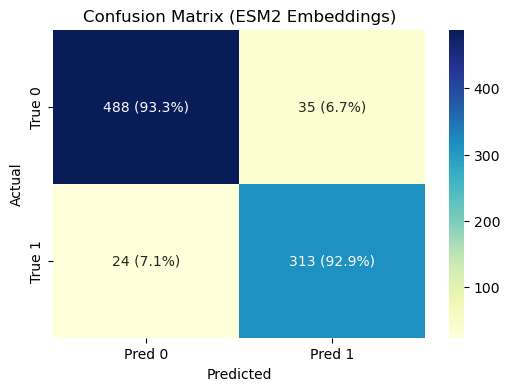

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       523
           1       0.90      0.93      0.91       337

    accuracy                           0.93       860
   macro avg       0.93      0.93      0.93       860
weighted avg       0.93      0.93      0.93       860



In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# Set the model to evaluation mode
model.eval()  

y_true = []
y_pred = []

# Iterate through the test_loader to get true labels and predictions
with torch.no_grad():
    for sequences, attention_masks, labels in test_loader:
        sequences, attention_masks, labels = sequences.to(device), attention_masks.to(device), labels.to(device)
        
        # Forward pass to get predictions
        outputs = model(sequences, attention_mask=attention_masks)
        
        # Apply a threshold to get binary predictions (e.g., if output > 0.5, predict 1; else, predict 0)
        predicted = (outputs > 0.5).float()
        
        # Store true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Combine total amounts and percentages
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        annot[i, j] = f"{cm[i, j]} ({cm_percentage[i, j]:.1f}%)"

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (ESM2 Embeddings)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('Figures/ConfusionMatrix_ESM2.png')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))


In [23]:
# Get the first batch from the test loader
for batch_idx, (batch_tokens, attention_mask, labels) in enumerate(test_loader):
    if batch_idx == 5:  # Get the fifth batch
        # Move the batch to the correct device
        batch_tokens = batch_tokens.to(device)
        attention_masks = attention_mask.to(device)

        model.eval()

        # Reset attention maps before forward pass
        model.attention_maps = []

        # Register hook for attention collection
        collect_attention = True
        if collect_attention:
            for attention_layer in model.attention_layers:  # Use attention_layers here
                attention_layer.register_forward_hook(model.save_attention)

        # Perform a forward pass with attention map collection
        with torch.no_grad():
            logits, attention_maps = model(batch_tokens, attention_masks, collect_attention=True)

        # Check if attention maps were collected
        if attention_maps:
            first_sample_attention_maps = attention_maps[0]  # First sample's attention maps
            # Print attention maps shape (for debugging)
            print(f"Shape of attention maps for first sample: {first_sample_attention_maps.shape}")
        else:
            print("No attention maps collected.")
        
        break  # Stop after processing the first batch


Shape of attention maps for first sample: torch.Size([4, 401, 401])


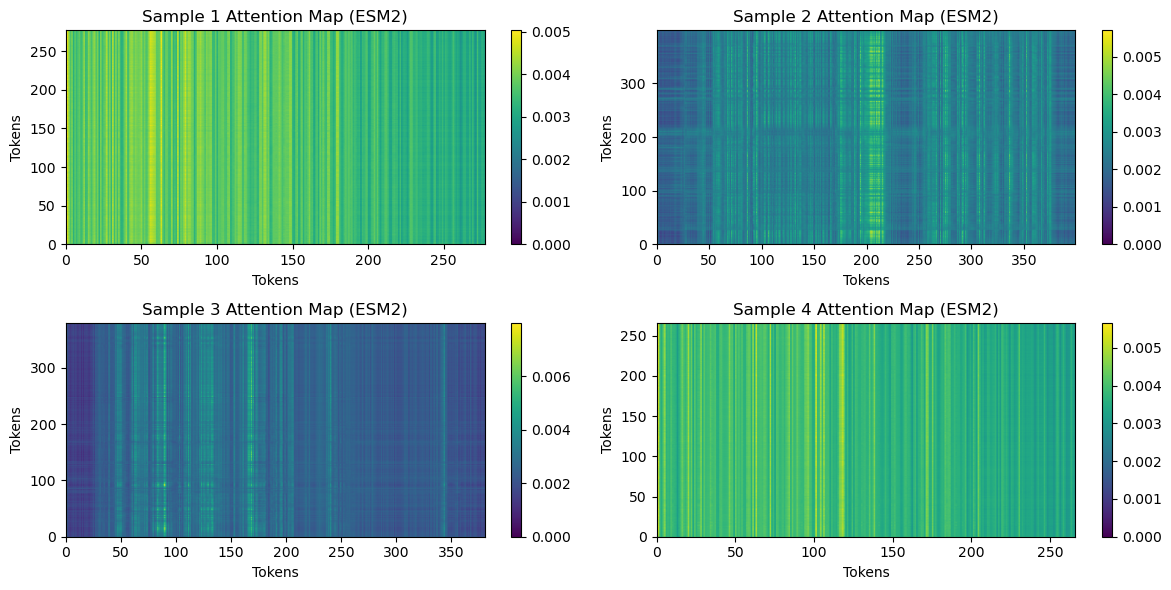

In [24]:
# Gather maps and masks, convert to numpy, and transfer to cpu for easy plotting
attention_maps = [first_sample_attention_maps[i].cpu().numpy() for i in range(4)]
attention_masks = attention_masks.cpu().numpy()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot each attention map
for idx, ax in enumerate(axes.flat):
    # Get the number of valid tokens from the attention mask (sum of 1s)
    valid_token_count = attention_masks[idx].sum()
    
    # Plot the attention map
    im = ax.imshow(
        attention_maps[idx][:valid_token_count, :valid_token_count],  # Slice to include only valid tokens
        cmap='viridis', 
        aspect='auto'
    )
    ax.set_title(f"Sample {idx + 1} Attention Map (ESM2)")
    
    # Set x-axis and y-axis labels
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Tokens")
    ax.set_xlim(0, valid_token_count - 1)
    ax.set_ylim(0, valid_token_count - 1)
    
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.savefig('Figures/AttentionMaps_ESM2.png')
plt.tight_layout()
plt.show()